In [11]:
import sys
from pathlib import Path

project_root = Path.cwd().parent   # one level up
sys.path.insert(0, str(project_root))
#Import the tools
from src.parse_atlas import parser
from src.calculations import physics_calcs, combinatorics
import math, awkward as ak, numpy as np
import atlasopenmagic as atom
import matplotlib.pyplot as plt
import os

In [12]:
root_files_path = "data/root_files/"
inv_mass_arrays = "data/inv_masses/"
# random_file = root_files_path + os.listdir(root_files_path)[5]
# test = parser.AtlasOpenParser.parse_root_file(random_file)

In [13]:
# Get all .npy files
inv_masses_raw = [f for f in os.listdir(inv_mass_arrays) if f.endswith(".npy")]
inv_masses_sizes = {f: os.path.getsize(os.path.join(inv_mass_arrays, f)) for f in inv_masses_raw}

biggest_file = max(inv_masses_sizes, key=inv_masses_sizes.get)
print(f"Chosen largest file: {biggest_file} ({inv_masses_sizes[biggest_file]} bytes)")

# Sort files by size and take the 9 largest
sorted_files = sorted(inv_masses_sizes.items(), key=lambda x: x[1], reverse=True)[:9]
selected_files = [f[0] for f in sorted_files]

Chosen largest file: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_1m_2j_.npy (128432 bytes)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

def choose_range_and_bins(arr):
    # clean NaNs / neg (if any) and get robust percentiles
    arr = np.asarray(arr)
    arr = arr[np.isfinite(arr)]
    arr = arr[arr >= 0]  # negative masses not physical here

    if arr.size == 0:
        return 0, 1, 10, "linear"

    p1, p99 = np.percentile(arr, [1, 99])
    p0, p100 = np.min(arr), np.max(arr)
    rng = max(p100, p99) - min(p0, p1)

    # Choose mass_min/mass_max based on percentiles to avoid outlier stretch
    mass_min = max(0.0, p1 - 0.05 * max(1.0, p1))   # a little padding
    mass_max = p99 + 0.05 * max(1.0, p99)

    # If the dynamic range is huge, prefer log bins
    if mass_max > 5000 or (mass_max / max(1e-6, mass_min) > 50):
        # log bins: avoid zero by starting a tiny positive value
        mass_min_for_log = max(1e-3, mass_min) 
        n_bins = 120 if mass_max <= 20000 else 200
        return mass_min_for_log, mass_max, n_bins

    # Otherwise linear bins, choose count by range
    if mass_max <= 300:
        n_bins = 80
    elif mass_max <= 2000:
        n_bins = 120
    elif mass_max <= 5000:
        n_bins = 160
    else:
        n_bins = 200

    return mass_min, mass_max, n_bins


# Plotting example for single file
file_path = os.path.join(inv_mass_arrays, "2024r-pp_231d93e4438adee5.root_FS_2e_5m_3j_5p_IM_2e_3j_1p_.npy")
inv_masses = np.load(file_path)

# mass_min, mass_max, n_bins = choose_range_and_bins(inv_masses)
# print(f"Auto-picked: min={mass_min:.3f} GeV, max={mass_max:.3f} GeV, bins={n_bins}, mode={mode}")

# plt.figure(figsize=(8,5))
# if mode == "linear":
#     plt.hist(inv_masses, bins=n_bins, range=(mass_min, mass_max), alpha=0.8)
# else:  # log
#     bins = np.logspace(np.log10(mass_min), np.log10(mass_max), n_bins+1)
#     plt.hist(inv_masses, bins=bins, alpha=0.8)
#     plt.xscale('log')



File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_1m_2j_.npy, min=57417.451, max=5090276.027, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_1m_2p_2j_.npy, min=41688.607, max=5013935.392, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_1m_2j_.npy, min=58781.389, max=5034242.303, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_2j_1p_.npy, min=38101.514, max=4674624.146, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_2j_.npy, min=58781.389, max=5034242.303, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2e_2p_2j_.npy, min=41688.607, max=5013935.392, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_1m_1p_2j_.npy, min=38101.514, max=4674624.146, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_1m_2j_1p_.npy, min=38101.514, max=4674624.146, bins=200
File: 2024r-pp_231d93e4438adee5.root_FS_2e_1m_2j_5p_IM_2j_2p_.npy, min=41688.607, max=5013935.392, bins=200
Saved f

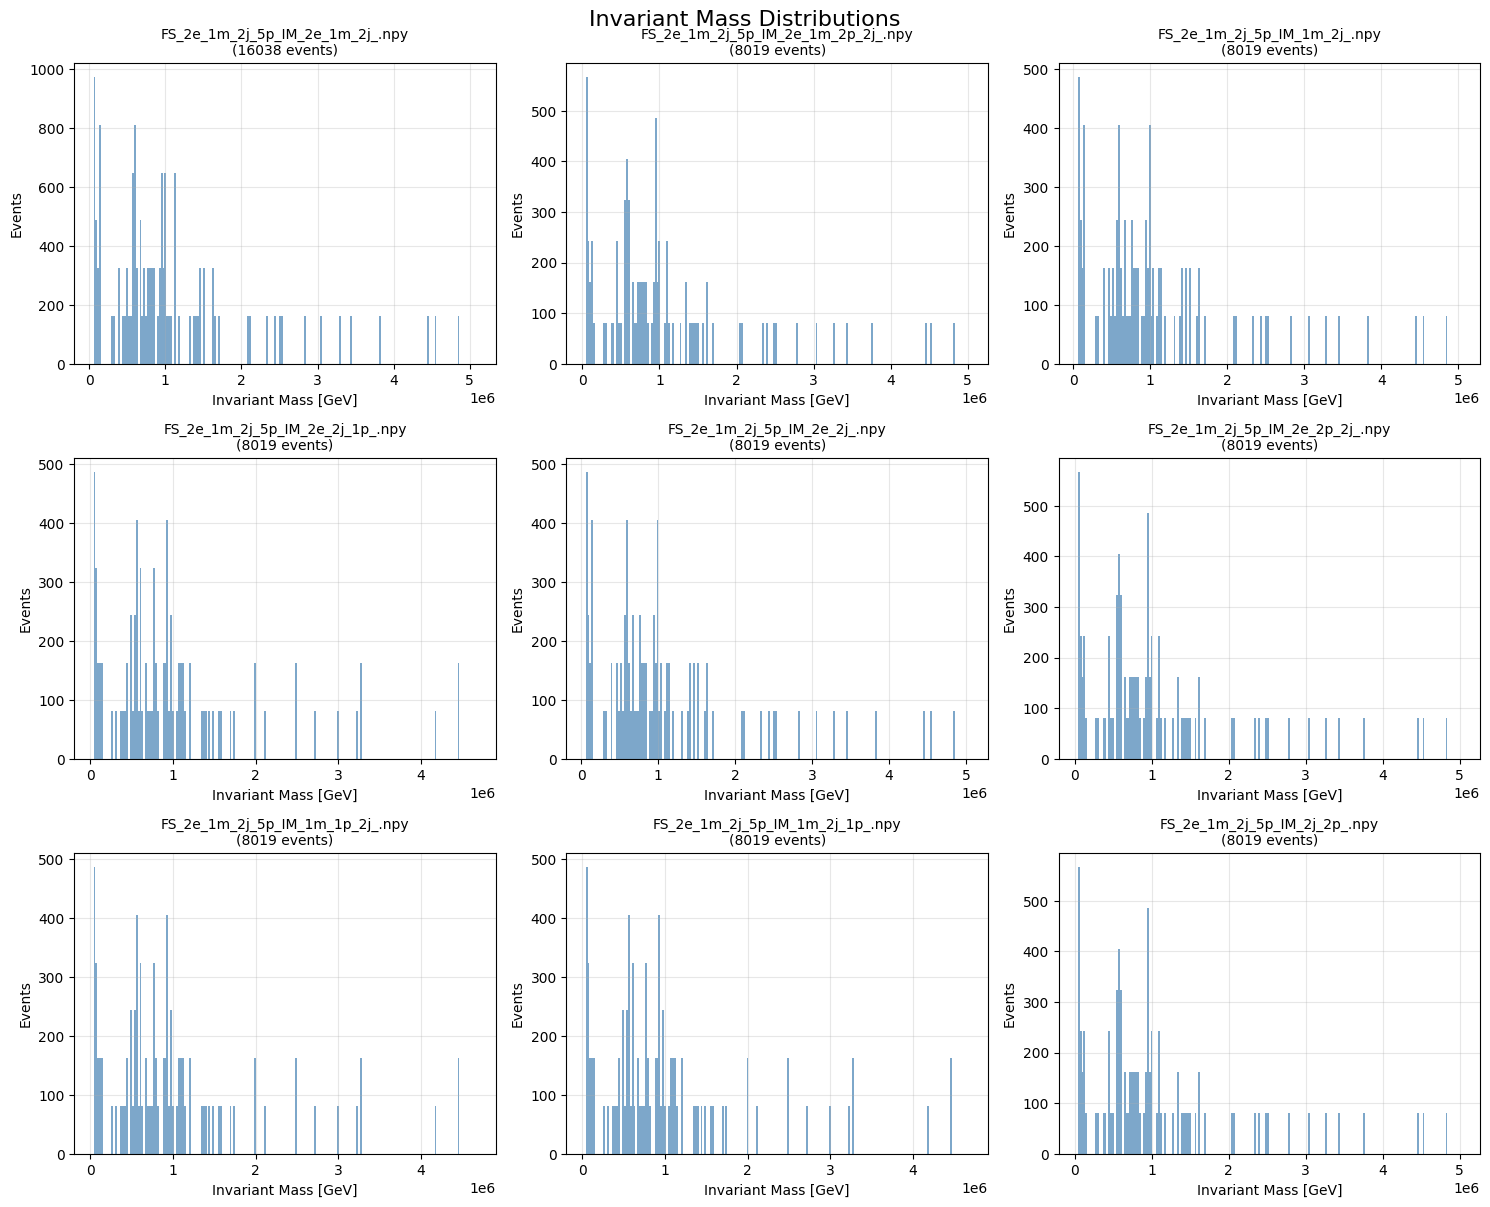

In [ ]:
# Histogram parameters
n_bins = 100
mass_min, mass_max = 0, 5000000

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Process each file
for idx, filename in enumerate(selected_files):
    file_path = os.path.join(inv_mass_arrays, filename)
    inv_masses = np.load(file_path)
    mass_min, mass_max, n_bins = choose_range_and_bins(inv_masses)
    print(f"File: {filename}, min={mass_min:.3f}, max={mass_max:.3f}, bins={n_bins}")
    # Create histogram
    bin_content, bin_edges = np.histogram(inv_masses, bins=n_bins, range=(mass_min, mass_max))
    bin_errors = np.sqrt(bin_content)

    # Plot on corresponding subplot
    ax = axes[idx]
    ax.hist(bin_edges[:-1], bins=bin_edges, weights=bin_content, alpha=0.7, color='steelblue')

    # Extract particle combination from filename
    # Format: year_<file_name>.root_FS_<final_sate>_IM_<combination>_.npy
    particle_combo = filename.split('FS')[0].split('.root_')[1]

    ax.set_xlabel("Invariant Mass [GeV]")
    ax.set_ylabel('Events')
    ax.set_title(f'{filename.split(".root_")[1]}\n({len(inv_masses)} events)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.suptitle('Invariant Mass Distributions', fontsize=16, y=1.002)
save_dir = os.path.join("plots")
os.makedirs(save_dir, exist_ok=True)
out_name = f"inv_mass_grid_{biggest_file.replace('.npy', '')}.png"
out_path = os.path.join(save_dir, out_name)
fig.savefig(out_path, bbox_inches='tight', dpi=150)
print(f"Saved figure to {out_path}")
plt.show()